##### Imports

In [18]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##### Hyperparameters

In [19]:
# output:
output_dir = './output/dense'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 100
pad_type = trunc_type = 'pre'

# neural network architecture:
n_dense = 64
dropout = 0.5

##### Load

In [20]:
# load data - x = reviews y = rating
(x_train, y_train),(x_valid, y_valid) = imdb.load_data(
    num_words=n_unique_words, 
    skip_top=n_words_to_skip
)

##### Examine

In [21]:
# show first 6 reviews
x_train[0:6]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [22]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [23]:
word_index = imdb.get_word_index()
word_index = { k: (v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = {v:k for k,v in word_index.items()}


In [24]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

##### Standardize review length

In [25]:
x_train = pad_sequences(x_train, 
                        maxlen=max_review_length,
                        padding=pad_type, 
                        truncating=trunc_type, 
                        value=0)

x_valid = pad_sequences(x_valid, 
                        maxlen=max_review_length, 
                        padding=pad_type, 
                        truncating=trunc_type, 
                        value=0)

In [26]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

##### Dense Network Setup

In [27]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                409664    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


##### Output

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(x_valid, y_valid), 
          callbacks=[modelcheckpoint])


Epoch 1/4
196/196 [==============================] - 9s 42ms/step - loss: 0.5433 - accuracy: 0.7038 - val_loss: 0.3603 - val_accuracy: 0.8390
Epoch 2/4
196/196 [==============================] - 3s 15ms/step - loss: 0.2682 - accuracy: 0.8934 - val_loss: 0.3462 - val_accuracy: 0.8469
Epoch 3/4
196/196 [==============================] - 2s 10ms/step - loss: 0.1047 - accuracy: 0.9700 - val_loss: 0.4353 - val_accuracy: 0.8333
Epoch 4/4
196/196 [==============================] - 1s 7ms/step - loss: 0.0236 - accuracy: 0.9961 - val_loss: 0.5355 - val_accuracy: 0.8310


In [29]:
x_valid[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,
        591,  202,    2,    2,    2,  717,    2,    2,    2,    2,    2,
          2,  360,    2,    2,  177,    2,  394,  354,    2,  123,    2,
       1035, 1035, 1035,    2,    2,    2,   92,  124,   89,  488,    2,
        100,    2, 1668,    2,    2,    2,    2,    2,    2,  220,  468,
          2,  124,    2,  286,  170,    2,  157,    2,    2,    2,  239,
          2,  179,    2,    2,    2,    2,    2,  451,  202,    2,    2,
        717], dtype=int32)

##### Predict

In [30]:
model.load_weights(output_dir+"/weights.02.hdf5")

prediction_index = 0
predictions = model.predict(x_valid)
predicted_sentiment = predictions[prediction_index][0]

print(predicted_sentiment)
print(' '.join(index_word[id] for id in x_valid[prediction_index]))

y_valid[prediction_index]


782/782 [==============================] - 1s 768us/step
0.06969262
PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK please give UNK UNK UNK miss UNK UNK UNK UNK UNK UNK rest UNK UNK cast UNK terrible performances UNK show UNK flat flat flat UNK UNK UNK don't know how michael UNK could UNK allowed UNK UNK UNK UNK UNK UNK almost seemed UNK know UNK wasn't going UNK work UNK UNK UNK performance UNK quite UNK UNK UNK UNK UNK fans give UNK UNK miss


0

##### Validation Review

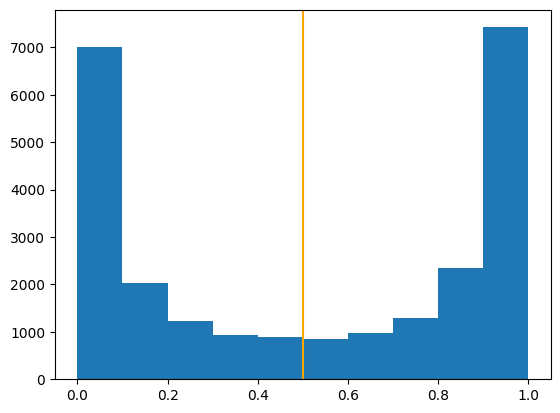

In [31]:
plt.hist(predictions)
_ = plt.axvline(x=0.5, color='orange')

In [32]:
pct_auc = roc_auc_score(y_valid, predictions) * 100.0
"{:0.2f}".format(pct_auc)

'92.77'

In [33]:
float_y_hat = []
for y in predictions:
    float_y_hat.append(y[0])

ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])
ydf.head(10)

,y_hat,y
0,0.069693,0
1,0.980628,1
2,0.856841,1
3,0.518478,0
4,0.991092,1
5,0.815040,1
6,0.888265,1
7,0.018339,0
8,0.886910,0
9,0.639055,1


##### False Positives and False Negatives

In [36]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
66,0.912889,0
75,0.922143,0
152,0.900889,0
299,0.937462,0
386,0.956497,0
390,0.921325,0
426,0.933701,0
455,0.929966,0
547,0.941378,0
555,0.924476,0


In [37]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
101,0.029055,1
300,0.049227,1
325,0.091152,1
333,0.058387,1
667,0.062123,1
747,0.077119,1
861,0.086287,1
973,0.065446,1
1192,0.083344,1
1297,0.070396,1
